# <center>Оптимизация маркетинговых затрат</center>

##### Изучить:

- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

##### Содержание:

1. [Описание](#info)
2. [Предобработка данных](#pretreatment)
3. [Метрики](#metrics)
     - [Продукт](#product)    
     - [Продажи](#sales)
     - [Маркетинг](#marketing)
4. [Рекомендации](#summary)

### Шаг 1.1 Загрузим данные<a id="info"></a>

##### Импорты:

In [1]:
import pandas as pd
import numpy as np 
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

##### Датасеты:

##### Лог сервера с информацией о посещениях сайта (visits):

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

##### Информация о заказах:

In [4]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка ~~название засекреченно~~ с этого заказа

##### Информация о затратах на маркетинг:

In [6]:
costs = pd.read_csv('/datasets/costs.csv')
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день
___

##### Вывод:

Таблица visits:
- Привести имена столбцов к нижнему регистру
- Преобразовать столбцы 'End Ts' и 'Start Ts' в формат datetime, переименовать

Таблица orders:
- Привести имена столбцов к нижнему регистру
- Преобразовать столбец 'Buy Ts' в формат datetime, переименовать

Таблица costs:
- Преобразовать столбец 'dt' в формат datetime, переименовать

### Шаг 1.2 Подготовим данные к анализу<a id="pretreatment"></a>

##### visits:

In [8]:
#приведем столбцы к нижнему регистру
visits.columns = map(str.lower, visits.columns)
#переименуем столбцы
visits = visits.rename(columns={'end ts':'end_ts', 'start ts':'start_ts', 'source id':'source_id'})
#приведем время к формату datetime
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')

##### orders:

In [9]:
#приведем столбцы к нижнему регистру
orders.columns = map(str.lower, orders.columns)
#переименуем столбцы
orders = orders.rename(columns={'buy ts':'buy_ts'})
#приведем время к формату datetime
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
orders['purchase_month'] = orders['buy_ts'].astype('datetime64[M]')

##### costs:

In [10]:
#приведем время к формату datetime
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs = costs.rename(columns={'dt':'acquisition_date'})

___

### Профили пользователей:

In [11]:
users = (visits.sort_values(by=['uid', 'start_ts'])
         .groupby('uid')
         .agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
         .rename(columns={'start_ts':'acquisition_ts'}))
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')
users = (users.reset_index()
        .set_index(['source_id', 'acquisition_date'])
        .join(costs.set_index(['source_id', 'acquisition_date']), how='left'))

In [12]:
user_cost = (users.groupby(['source_id', 'acquisition_date'])
            .agg({'device':'count', 'costs':'max'})
             .rename(columns={'device':'users'}))
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acquisition_cost']], how='left').reset_index()
users = users.set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month',
                               'source_id', 'device', 'acquisition_cost']]

In [13]:
users = users.join(orders.groupby('uid').agg({'buy_ts':'min'}).rename(columns={'buy_ts':'first_purchase_dt'}), how='left')
users['payer'] = ~users['first_purchase_dt'].isna()
users.head(3)

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost,first_purchase_dt,payer
uid,,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-09-11 00:06:00,True
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6,NaT,False
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6,2017-06-01 09:23:00,True


### Шаг 2. Построим отчёты и посчитаем метрики<a id="metrics"></a>

- [Продукт](#product)    
- [Продажи](#sales)
- [Маркетинг](#marketing)

### Продукт:<a id="product"></a>

- [Сколько людей пользуются в день, неделю, месяц?](#daumauwau)
- [Сколько сессий в день?](#visits_per_day)
- [Сколько длится одна сессия? (ASL)](#asl)
- [Как часто люди возвращаются? (Retention Rate)](#retention_rate)

- ##### Сколько людей пользуются в день, неделю, месяц?<a id="daumauwau"></a>

Выделим в отдельные столбцы дату, неделю и месяц:

In [14]:
visits['session_date'] = visits['start_ts'].dt.date
visits['session_week'] = visits['start_ts'].dt.week
visits['session_month'] = visits['start_ts'].dt.month

In [15]:
visits_day_users = visits.groupby('session_date').agg({'uid':'nunique'})

Посчитаем метрики:
- DAU (от англ. daily active users) — количество уникальных пользователей в день
- WAU (от англ. weekly active users) — количество уникальных пользователей в неделю
- MAU (от англ. monthly active users) — количество уникальных пользователей в месяц

In [16]:
visits_dau = visits.groupby(['session_date','source_id','device']).agg({'uid': 'nunique'}).reset_index()
visits_wau = visits.groupby(['session_week','source_id','device']).agg({'uid': 'nunique'}).reset_index()
visits_mau = visits.groupby(['session_month','source_id','device']).agg({'uid': 'nunique'}).reset_index()

Создадим функцию, которая будет строить графики для каждой группы уникальных пользователей:

In [17]:
def active_users_to_plot(data):
    sns.relplot(
    data=data,
    kind='line',
    x=data.columns[0],
    y='uid',
    hue='source_id',
    row='device',
    legend='full',
    palette='tab10',
    aspect=18/8);

#### <center>Графики DAU с разбивкой по устройствам и рекламным источникам:</center>

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


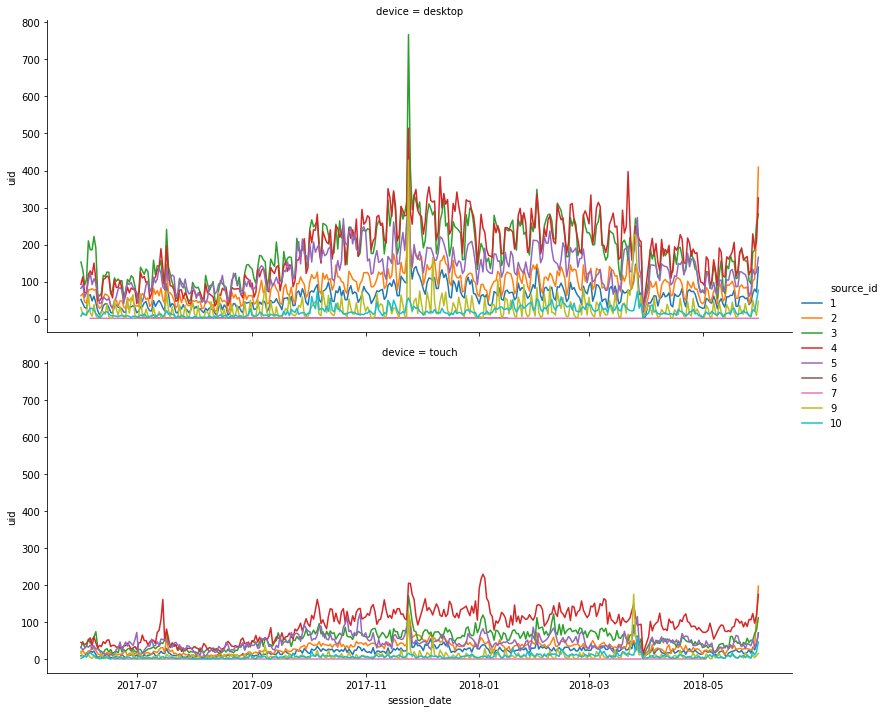

In [18]:
active_users_to_plot(visits_dau)

In [19]:
print('Среднее кол-во активных пользователей в день:', visits.groupby('session_date').agg({'uid':'nunique'})['uid'].mean().round())

Среднее кол-во активных пользователей в день: 908.0


#### <center>Графики WAU c разбивкой по устройствам и по рекламным источникам:</center>

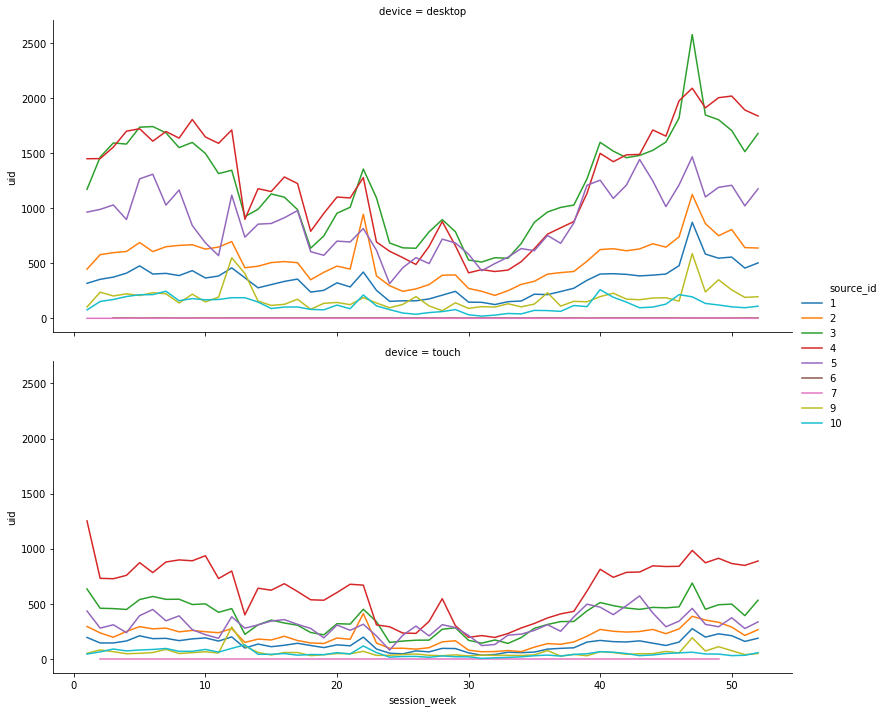

In [20]:
active_users_to_plot(visits_wau)

In [21]:
print('Среднее кол-во уникальных пользователей в неделю:',visits.groupby('session_week').agg({'uid':'nunique'})['uid'].mean().round())

Среднее кол-во уникальных пользователей в неделю: 5825.0


#### <center>Графики MAU c разбивкой по устройствам и по рекламным источникам:</center>

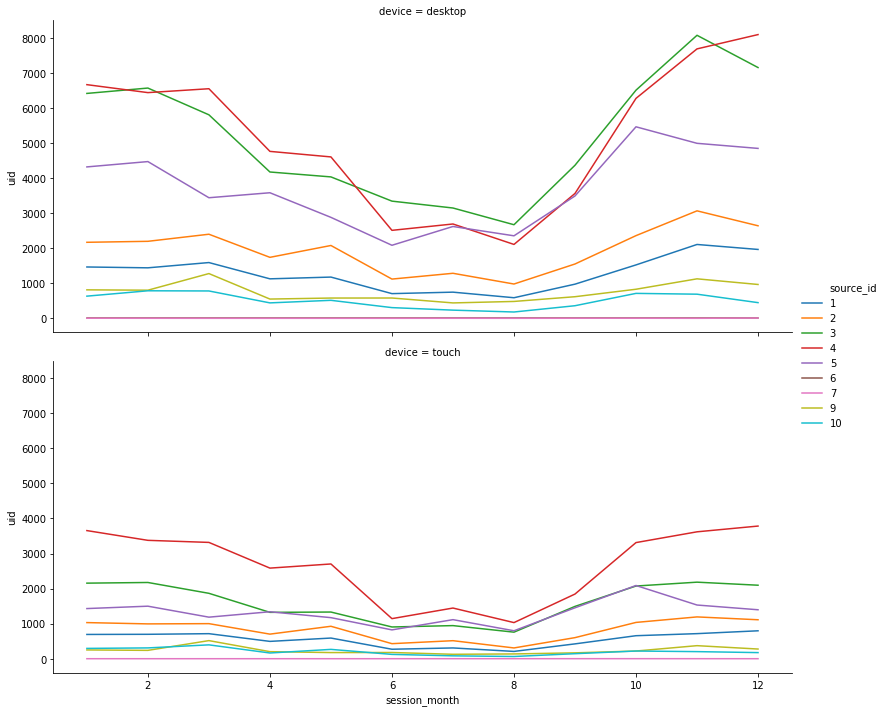

In [22]:
active_users_to_plot(visits_mau)

In [23]:
print('Среднее кол-во уникальных пользователей в месяц:', visits.groupby('session_month').agg({'uid':'nunique'})['uid'].mean().round())

Среднее кол-во уникальных пользователей в месяц: 23228.0


___

##### Вывод:
На графике MAU наблюдается снижение новых пользователей в ноябре (5 месяц), где значения сохраняются вплоть до февраля (8 месяц), после чего снова начинают расти, из чего можно сделать вывод, что люди предпочитают не покупать билеты зимой

- ##### Сколько сессий в день?<a id="visits_per_day"></a>

Построим среднее кол-во сколько сессий в день:

In [24]:
visits_per_day = visits.groupby('session_date').agg({'uid': ['count','nunique']})
visits_per_day.columns = ['n_sessions', 'n_users']
visits_per_day['sessions_per_user'] = (visits_per_day['n_sessions'] / visits_per_day['n_users']).round(1)

In [25]:
print('Среднее количество сессий в день:', int(visits_per_day['n_sessions'].mean()))
print('Среднее количество сессий в день на одного человека:', int(visits_per_day['sessions_per_user'].mean()))

Среднее количество сессий в день: 987
Среднее количество сессий в день на одного человека: 1


___

Построим таблицу кол-ва сессий по месяцам:

In [26]:
visits_per_month = visits.groupby('session_month').agg({'uid': ['count','nunique']})
visits_per_month.columns = ['n_sessions', 'n_users']
#рассчитаем, сколько сессий приходится на одного пользователя за месяц
visits_per_month['sessions_per_user'] = (visits_per_month['n_sessions'] / visits_per_month['n_users']).round(1)
visits_per_month.T

session_month,1,2,3,4,5,6,7,8,9,10,11,12
n_sessions,36939.0,37182.0,35679.0,26515.0,26635.0,16505.0,17828.0,14355.0,23907.0,37903.0,43969.0,41983.0
n_users,28716.0,28749.0,27473.0,21008.0,20701.0,13259.0,14183.0,11631.0,18975.0,29692.0,32797.0,31557.0
sessions_per_user,1.3,1.3,1.3,1.3,1.3,1.2,1.3,1.2,1.3,1.3,1.3,1.3


In [27]:
print('Среднее количество сессий в месяц:', int(visits_per_month['n_sessions'].mean()))

Среднее количество сессий в месяц: 29950


- ##### Сколько длится одна сессия? (ASL)<a id="asl"></a>

Расчитаем среднюю продолжительность сессии в секундах (Average Session Length, ASL):

In [28]:
visits['asl'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Посмотрим на распределение:

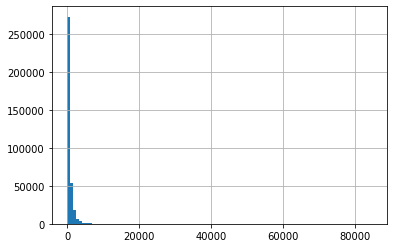

In [29]:
visits['asl'].hist(bins=100);

Определим моду, т.к. распределение далеко от нормального:

In [30]:
print('Средняя продолжительность сессии:', visits['asl'].mode()[0], 'секунд')

Средняя продолжительность сессии: 60 секунд


- ##### Как часто люди возвращаются? (Retention Rate)<a id="retention_rate"></a>

In [31]:
#возьмем дату, когда пользователь впервые проявил активность и объеденим с исходным датафреймом visits
first_visit_date = visits.groupby('uid')['session_date'].min()
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date, on='uid')

#выделим месяцы из 'session_date' и 'first_visit_date'
visits['visit_month'] = visits['session_date'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')

#рассчитаем lifetime пользователя в рамках когорты
visits['cohort_lifetime'] = ((visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1,'M')).round().astype(int)

#сгруппируем данные по когорте и lifetime 
visits_cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

#найдем исходное кол-во пользователей в когорте и переименуем в 'cohort_users'
initial_uid_count = visits_cohorts[visits_cohorts['cohort_lifetime'] == 0][['first_visit_month', 'uid']] 
initial_uid_count = initial_uid_count.rename(columns={'uid':'cohort_users'})

#объеденим данные по когортам с исходным кол-вом пользователей в когорте
visits_cohorts = visits_cohorts.merge(initial_uid_count, on='first_visit_month')

#рассчитаем retention rate и построим сводную таблицу
visits_cohorts['retention_rate'] = visits_cohorts['uid'] / visits_cohorts['cohort_users']
retention_pivot = visits_cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention_rate', aggfunc='sum')

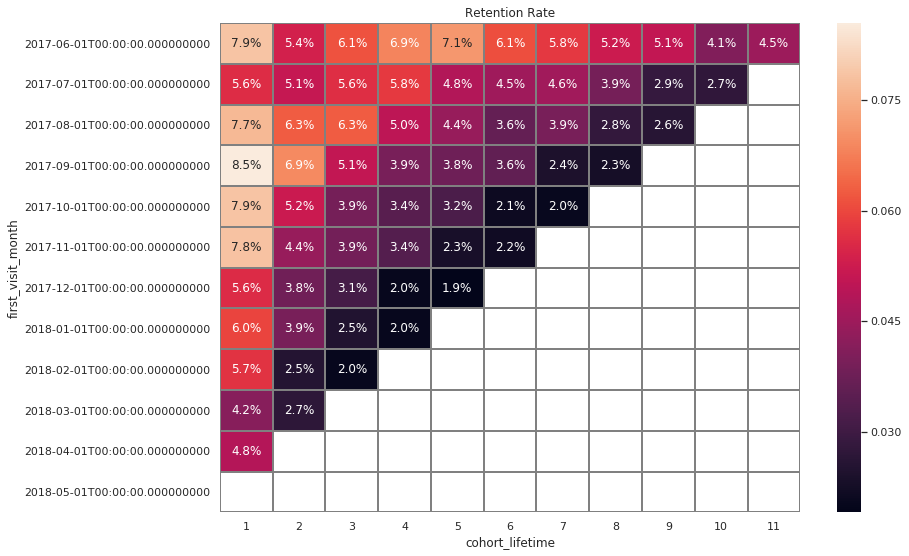

In [32]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot.drop(columns=0), annot=True, fmt='.1%', linewidths=1, linecolor='gray');

##### Вывод:
Из тепловой карты видно, что люди крайне редко возвращаются на сайт после первого посещения. Можно предположить, что люди не так часто покупают билеты на различные мероприятия и концерты онлайн.

___

### Продажи:<a id="sales"></a>

- [Когда люди начинают покупать?](#first_purchase)
- [Сколько раз покупают за период?](#avg_purchase_count)
- [Какой средний чек?](#avg_bill)
- [Сколько денег приносят? (LTV)](#ltv)

##### - Когда люди начинают покупать?<a id="first_purchase"></a>

Найдем разницу между временем первой покупки и первого захода:

In [33]:
#первый заход
user_first_visit =  visits.groupby('uid')['start_ts'].min()
#первая покупка
user_first_order = orders.groupby('uid')['buy_ts'].min()
#соеденим таблицы
first_purchase = user_first_visit.to_frame().join(user_first_order.to_frame(), on = 'uid', how = 'inner')

In [34]:
#разницу между временем первой покупки и первого захода
first_purchase['difference_ts'] = first_purchase['buy_ts'] - first_purchase['start_ts']
#переведем в минуты
first_purchase['difference_ts'] = first_purchase['difference_ts'] / np.timedelta64(1, 'm')
first_purchase = first_purchase.query('difference_ts > 0')

Посмотрим гистрограмму распределения времени, за которое произошла первая покупка:

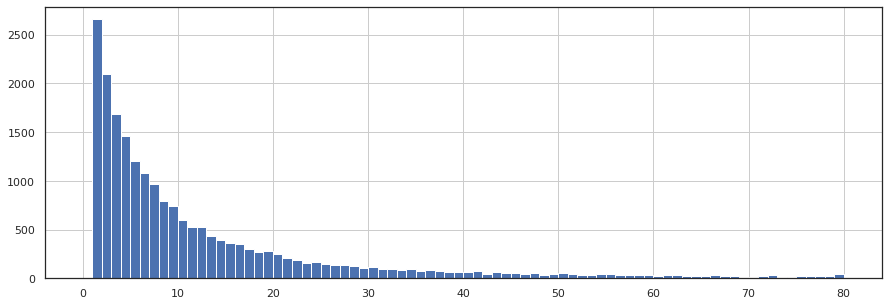

In [35]:
first_purchase['difference_ts'].hist(bins=80, range=(0,80), figsize=(15,5));

In [36]:
print('Чаще всего пользователь покупает в течении:', first_purchase['difference_ts'].mode()[0], 'минут')

Чаще всего пользователь покупает в течении: 1.0 минут


- ##### Сколько раз покупают за период?<a id="avg_purchase_count"></a>

In [37]:
orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_week'] = orders['buy_ts'].dt.week
orders['buy_month'] = orders['buy_ts'].dt.month

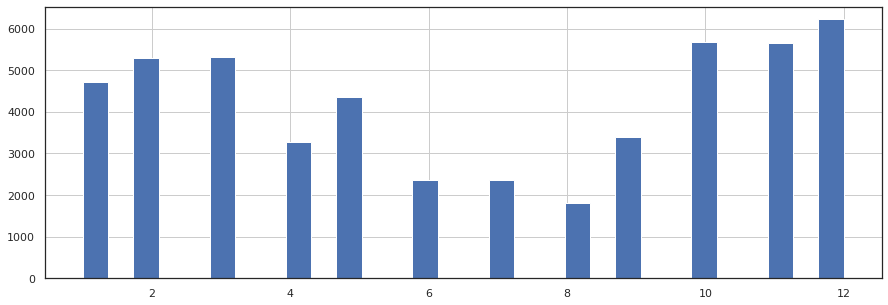

In [38]:
orders['buy_month'].hist(bins="auto", figsize=(15,5));

In [39]:
print('В среднем за месяц покупают:', orders.groupby('buy_month')['uid'].count().mean().round())

В среднем за месяц покупают: 4201.0


___

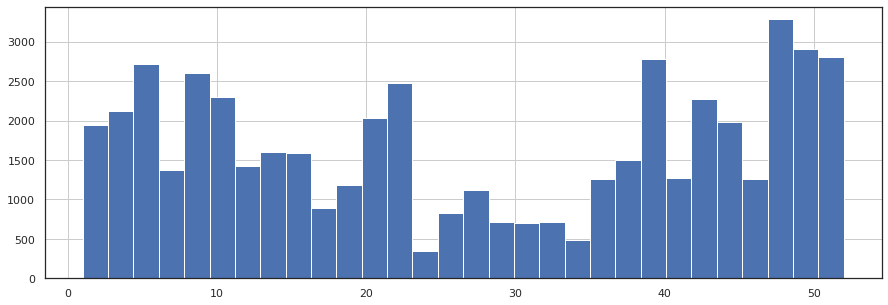

In [40]:
orders['buy_week'].hist(bins="auto", figsize=(15,5));

In [41]:
print('В среднем за неделю покупают:', orders.groupby('buy_week')['uid'].count().mean().round())

В среднем за неделю покупают: 970.0


___

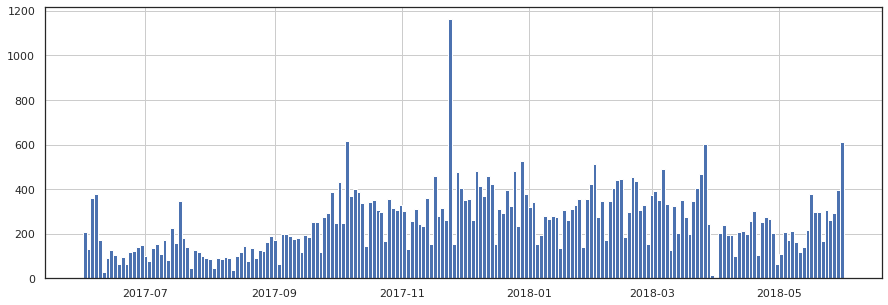

In [42]:
orders['buy_date'].hist(bins=200, figsize=(15,5));

In [43]:
print('В среднем за неделю покупают:', orders.groupby('buy_date')['uid'].count().mean().round())

В среднем за неделю покупают: 139.0


- ##### Какой средний чек?<a id="avg_bill"></a>

Как с течением времени изменяется средний чек — сумма покупок, делённая на число покупателей.

Посмотрим изменение среднечего чека по месяцам в течении года:

In [44]:
#выделим месяцы из дат
orders['buy_ts_month'] = orders['buy_ts'].astype('datetime64[M]')


#сгруппируем данные по дате 
avg_bill = orders.groupby('buy_ts_month')['uid', 'revenue'].agg({'uid':'nunique', 'revenue':'sum'})
avg_bill['avg_bill'] = avg_bill['revenue'] / avg_bill['uid']

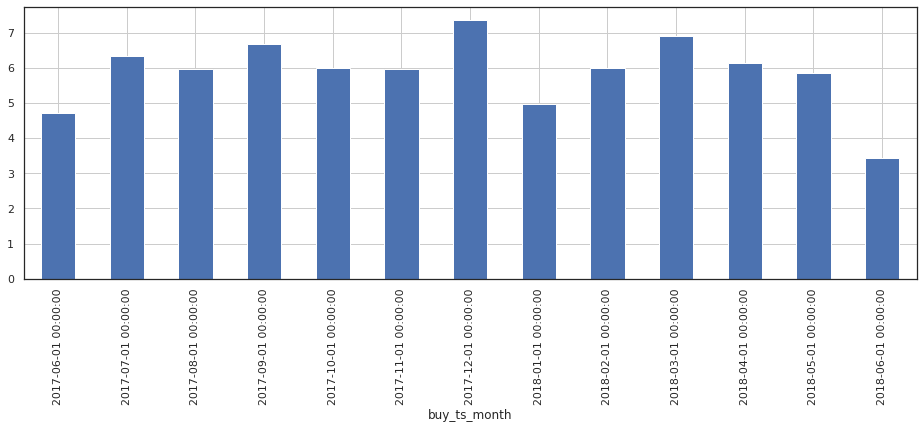

In [45]:
avg_bill['avg_bill'].plot(kind='bar',grid=True, figsize=(16,5));

In [46]:
print('Средний месячный чек:', avg_bill['avg_bill'].mean().round(2), 'у.е.')

Средний месячный чек: 5.87 у.е.


- ##### Сколько денег приносят? (LTV)<a id="ltv"></a>

In [47]:
#сформируем когорты
dimensions = ['source_id']
cohorts = (users.groupby(dimensions)
          .agg({'payer':'sum', 'acquisition_cost':'sum'})
          .rename(columns={'payer':'cohort_size'}))
cohorts['cac'] = cohorts['acquisition_cost'] / cohorts['cohort_size']

In [48]:
# рассчитаем ltv
ltv = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'source_id', 'device',
                                                      'purchase_month', 'revenue']]
ltv['age_month'] = ((ltv['purchase_month'] - ltv['acquisition_month']) / np.timedelta64(1,'M')).round().astype('int')
ltv = ltv.groupby(dimensions + ['age_month']).agg({'revenue':'sum'})
ltv = pd.pivot_table(ltv, index=dimensions, columns='age_month', values='revenue', aggfunc='sum')
ltv = ltv.cumsum(axis=1)
ltv = cohorts[['cohort_size']].join(ltv)
ltv = ltv.div(ltv['cohort_size'], axis=0).drop(columns=['cohort_size'])

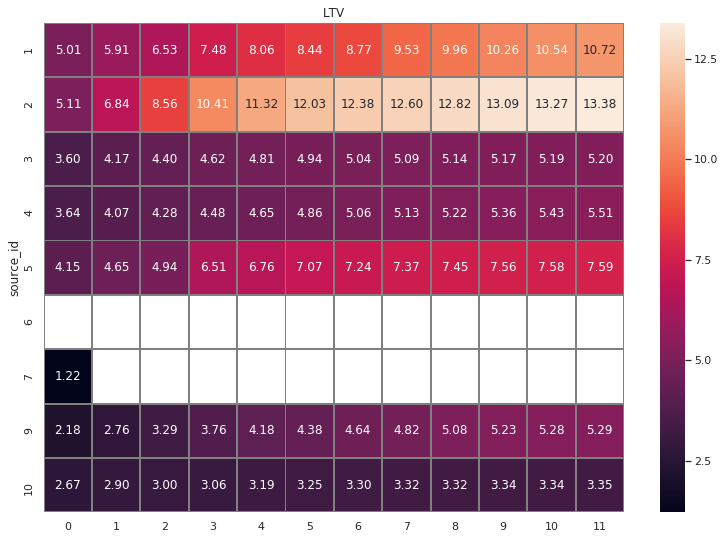

In [49]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

##### Вывод:
1. Больше всего денег принесли 1ый и 2ой источники
2. Меньше всего - 10ый, тогда как 6ой и 7ой не принесли почти ничего 

### Маркетинг:<a id="marketing"></a>

- [Сколько денег потратили? Всего / на каждый источник / по времени](#total_costs)
- [Сколько стоило привлечение одного покупателя из каждого источника? (CAC)](#cac)
- [На сколько окупились расходы? (ROI)](#roi)

##### - Сколько денег потратили? Всего / на каждый источник / по времени<a id="total_costs"></a>

Возьмем месяцы за временной период, по которому будем смотреть кол-во затраченных средств

In [50]:
costs['preiod_month'] = costs['acquisition_date'].dt.to_period('M')
costs['month'] = costs['acquisition_date'].astype('datetime64[M]')
costs_pivot = costs.pivot_table(index='preiod_month', columns='source_id', values='costs', aggfunc='sum')

preiod_month,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,total
source_id,,,,,,,,,,,,,
1,1125.61,1072.88,951.81,1502.01,2315.75,2445.16,2341.20,2186.18,2204.48,1893.09,1327.49,1467.61,20833.27
2,2427.38,2333.11,1811.05,2985.66,4845.00,5247.68,4897.80,4157.74,4474.34,3943.14,2993.70,2689.44,42806.04
3,7731.65,7674.37,6143.54,9963.55,15737.24,17025.34,16219.52,14808.78,14228.56,13080.85,9296.81,9411.42,141321.63
4,3514.80,3529.73,3217.36,5192.26,6420.84,5388.82,7680.47,5832.79,5711.96,5961.87,4408.49,4214.21,61073.60
5,2616.12,2998.14,2185.28,3849.14,5767.40,6325.34,5872.52,5371.52,5071.31,4529.62,3501.15,3669.56,51757.10
9,285.22,302.54,248.93,415.62,609.41,683.18,657.98,547.16,551.50,480.29,373.49,362.17,5517.49
10,314.22,329.82,232.57,460.67,627.24,792.36,645.86,614.35,480.88,526.41,388.25,409.86,5822.49
total,18015.00,18240.59,14790.54,24368.91,36322.88,37907.88,38315.35,33518.52,32723.03,30415.27,22289.38,22224.27,329131.62


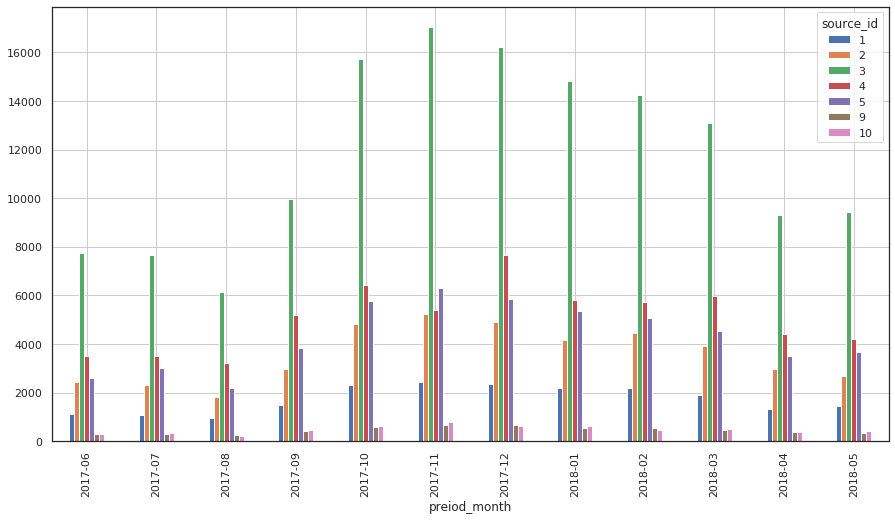

In [51]:
costs_pivot.plot(kind='bar', figsize=(15,8), grid=True);
costs.pivot_table(index='preiod_month', columns='source_id', values='costs', aggfunc='sum', margins=True, margins_name='total').T

##### Вывод:
- Больше всего денег на рекламу потратили в ноябре(2017-10), декабре(2017-11) и январе(2018-01) 
- Больше всего денег тратится на 3ий источник, меньше всего - на 10ый и 9ый

##### - Сколько стоило привлечение одного покупателя из каждого источника (CAC)?<a id="cac"></a>

source_id,1,2,3,4,5,7,9,10
cac,7.186364,12.209367,13.493901,5.931779,7.467378,0.0,5.013254,4.380075


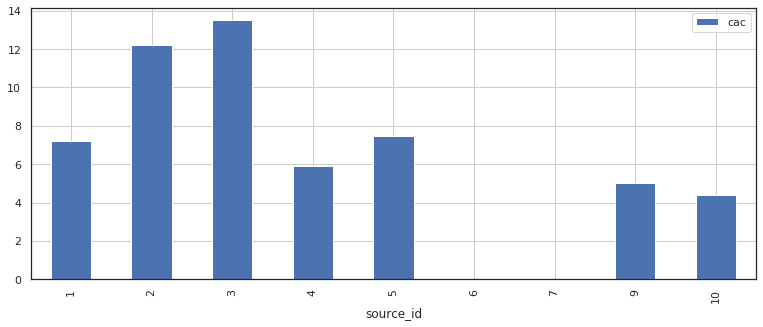

In [52]:
cohorts.reset_index().plot(x='source_id', y='cac', kind='bar', grid=True, figsize=(13,5));
cohorts.pivot_table(index='source_id', values='cac').T

##### Вывод:

Самая высокая стоимость привлечения клиента - у источников 2 и 3, в 12.2 у.е. и 13.5 у.е.

##### - На сколько окупились расходы? (ROI)<a id="roi"></a>

In [53]:
romi = cohorts[['cac']].join(ltv)
romi = romi.div(romi['cac'], axis=0).drop(columns=['cac'])
romi = romi.drop([6,7], axis=0).fillna('')

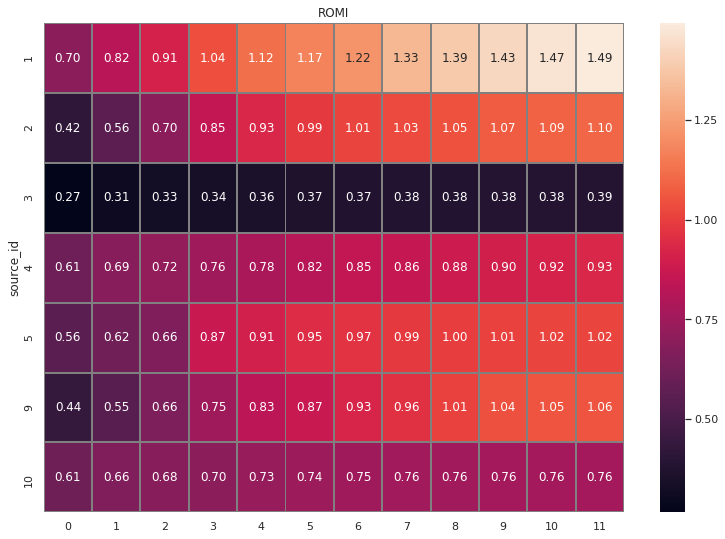

In [54]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

##### Вывод:
1. 1ый источник окупился быстрее всех, на 4ый месяц и продолжал расти
2. 2ой источник довольно быстро окупился к 7му месяцу и продолжал приносить прибыль.
3. 3ий источник растет лишь на процент ежемесячно, при нынешнем темпе окупаемость ожидается через 6 лет.
4. Ожидается, что 4ый источник начнет приносить прибыль через 2-3 месяца
5. 5ый источник окупился на 9ый месяц и продолжал приносить прибыль 
6. 9ый источник также окупился на 9ый месяц и продолжал приносить прибыль
7. Последние 5 месяцев 10ый источник остановился в росте и тенденции к окупаемости не наблюдается 

### Рекомендации:<a id="summary"></a>

1. Продолжать вкладывать деньги в 1ый, 2ой, 5ый и 9ый источники, т.к. ROI этих источников более 100%, т.е. они окупают свои вложения.
2. Потенциально прибыльным можно назвать 4ый источник, рекомендуется увеличить вложения в него либо найти возможность снижения стоимости привлечения покупателя.
3. Прекратить вложения в 3ий и 10ый источники, т.к. затраты в них значительно превышают доход и их окупаемость ожидается не скоро.

### Вывод:
1. Кол-во уникальных пользователей:
    - В день (DAU): 908
    - В неделю (WAU): 5825
    - В месяц (MAU): 23228   
2. Среднее кол-во сессий в день: 987
    - Среднее кол-во сессий на одного человека: 1
3. Средняя длительность одной сессии (ASL): 60 секунд
4. Как часто люди возвращаются (Retention Rate): [Retention Rate](#retention_rate)
5. Когда люди начинают покупать: чаще всего покупают в течении 1 минуты
6. Сколько в среднем покупают за период:
    - В день: 139
    - В неделю: 970
    - В месяц: 4201
7. Средний чек: 5.87 у.е. в месяц
8. Сколько денег приносят (LTV): [LTV](#ltv)
9. Сколько денег потратили на каждый источник: [Ссылка](#total_costs)
10. Стоимость привлечения одного покупателя из каждого источника (CAC): [CAC](#cac)
11. На сколько окупились расходы (ROI): [ROI](#roi)